# Task 1 - Classification
- The task poses with the challenge to train a neural classifier to classify images into one of 100 predefined labels (selected from the dataset)
- To do this, we will train a CNN (Convolutional Neural Network) on the different datasets generated and see how hyperparameter tuning affects its output. 

In [2]:
# Dependencies
import matplotlib.pyplot as plt
import os
from PIL import Image, ImageDraw, ImageFont
import random
from random_word import RandomWords
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import transforms
import shutil
import numpy as np
from sklearn.model_selection import train_test_split

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [6]:
# 100 random words for dataset
def generate_random_words(num_words):
    r = RandomWords()
    words = []
    while len(words) < num_words:
        word = r.get_random_word()
        if word and 5 <= len(word) <= 9:
            words.append(word)

    return words

words = generate_random_words(100)
print(words)

['routed', 'xylylene', 'snailfish', 'elohimic', 'tarpaulin', 'scalping', 'retinned', 'burglar', 'pacifical', 'carbamido', 'mayoress', 'unaisled', 'conubium', 'incurs', 'vaginitis', 'untrodden', 'tipmen', 'jewism', 'ferniest', 'socius', 'acned', 'calvarium', 'tursha', 'metheglin', 'excitate', 'ectopias', 'corone', 'sinful', 'bedazzled', 'aroxyl', 'sumpweeds', 'triage', 'tubbeck', 'quercetum', 'kicky', 'crucilly', 'occupant', 'wineglass', 'solfatara', 'meisje', 'augurous', 'amalgam', 'atnah', 'pallia', 'firth', 'dippier', 'glossata', 'purfles', 'exodus', 'brazilin', 'erbium', 'snoringly', 'curdly', 'scolders', 'salagrama', 'pythia', 'foliation', 'showyard', 'spatio', 'unfleece', 'anglings', 'cowpony', 'bedoyo', 'jitters', 'aliquant', 'pentosan', 'weldors', 'indazine', 'panderous', 'clarini', 'belauds', 'echoist', 'asthenic', 'utterance', 'orthocym', 'curse', 'stomached', 'diatomist', 'pines', 'thorter', 'cointreau', 'outrow', 'claybanks', 'mafura', 'leucaemic', 'wommera', 'vodkas', 'quot

## Generation of the easy set
The basic features of this dataset include
- Singular text font - OpenSans-Regular.ttf
- The text color is fixed to be black and background to be white. (grayscale)
- The text is not centered and is randomly positioned in the image.

In [ ]:
if os.path.exists("content/dataset/easy"):
    shutil.rmtree("content/dataset/easy")

if not os.path.exists("content/dataset"):
    os.makedirs("content/dataset")
if not os.path.exists("content/dataset/easy"):
    os.makedirs("content/dataset/easy")

def generate_easy_set():
    font_path = "Fonts/OpenSans-Regular.ttf"
    if not os.path.exists(font_path):
        raise FileNotFoundError(f"Font file not found: {font_path}")
    output_dir = "content/dataset/easy"
    os.makedirs(output_dir, exist_ok=True)
    
    for i in range(0, 100):
        for word in words:
            width, height = 248, 80
            color = 255
            image = Image.new("L", (width, height), color)
            draw = ImageDraw.Draw(image)
            try:
                font = ImageFont.truetype(font_path, 36)
            except OSError as e:
                print(f"Error loading font: {e}")
                return
            text = word.title()
            text_bbox = font.getbbox(word)
            text_width = text_bbox[2] - text_bbox[0]
            text_height = text_bbox[3] - text_bbox[1]
            # random positioning
            x = random.randint((width - text_width)//8, 7*((width - text_width)//8))
            y = random.randint((height - text_height)//8, 7*((height - text_height)//8))
            position = (x, y)
            text_color = 0
            draw.text(position, text, font=font, fill=text_color)
            image.save(os.path.join(output_dir, f"{word}_{i}.png"))

generate_easy_set()

## Dataset Formatting
The class `WordImageDataset` has the following functionalities
- Initialize Dataset: Reads image files from a directory and extracts unique words as class labels.
- Create Label Mappings: Assigns each word a unique numerical index for classification.
- Store Image Paths & Labels: Maintains a list of file paths and their corresponding labels.
- Dataset Length (__len__): Returns the total number of images.
- Load Image (__getitem__): Opens an image, converts it to grayscale, applies transformations (if any), and returns the image-label pair.

Why This Approach?
- Efficient Data Handling: Loads and preprocesses images dynamically rather than storing them all in memory.
- Automated Labeling: Extracts labels from filenames, removing the need for manual annotation files.
- Supports Transformations: Allows easy integration of resizing, normalization, and augmentations for better model training.

In [280]:
class WordImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.images = []
        self.labels = []
        self.label_to_idx = {}
        self.idx_to_label = {}

        # Get all unique words (labels)
        words = set()
        for filename in os.listdir(image_dir):
            word = filename.split('_')[0]
            words.add(word)

        # Create label mappings
        for idx, word in enumerate(sorted(words)):
            self.label_to_idx[word] = idx
            self.idx_to_label[idx] = word

        # Load all images and labels
        for filename in os.listdir(image_dir):
            if filename.endswith('.png'):
                word = filename.split('_')[0]
                self.images.append(os.path.join(image_dir, filename))
                self.labels.append(self.label_to_idx[word])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        image = Image.open(image_path).convert('L')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

## Training a basic CNN
The model of choice is CNN, a Convolutional Neural Network, which is a standard architecture for image classification. CNNs are effective because they can automatically detect features like edges, textures, and patterns without requiring manual feature extraction.
### Basic Architecture
A typical CNN consists of the following layers:

1. Convolutional Layer (Conv Layer)
    - The core building block of a CNN, responsible for feature extraction.
    - Uses a filter (kernel) that slides over the input image, detecting patterns like edges or textures.
    - Output of this operation is called a feature map.
    - `nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)`
2. Activation Function (ReLU - Rectified Linear Unit)
    - Applies a non-linearity to the feature maps, introducing the ability to learn complex patterns.
    - Helps avoid the vanishing gradient problem.
    - `nn.ReLU()` 
3. Pooling Layer (Max Pooling or Average Pooling)
    - Reduces the spatial dimensions of feature maps while keeping important information.
    - Helps make the model translation-invariant and improves computational efficiency.
    - `nn.MaxPool2d(kernel_size, stride)`
4. Fully Connected Layer (FC Layer)
    - The final layers in a CNN, which convert the extracted features into predictions.
    - Flattens the feature maps and passes them through dense layers.
    - `nn.Linear(in_features, out_features)`

Since the input images are of size 248*80 pixels, the below architecture seemed to work best along with introduction of `GradScaler`, `autocast` and `dropout`.

1. GradScaler (`torch.amp.GradScaler()`)
    - Purpose: Helps with mixed-precision training, which speeds up training and reduces memory usage.
    - How?: It scales the loss value to prevent underflow when using half-precision (float16) computations.
    - Benefit: Ensures stable updates to model weights while taking advantage of faster, lower-precision arithmetic.
2. autocast (`torch.amp.autocast()`)
    - Purpose: Dynamically switches between float16 and float32 precision during forward passes.
    - How?: Uses float16 for less critical operations (e.g., matrix multiplications) and float32 for sensitive calculations (e.g., loss computation).
    - Benefit: Improves computational efficiency while maintaining numerical stability.
3. Dropout (`nn.Dropout()`)
    - Purpose: Reduces overfitting by randomly setting some neuron activations to zero during training.
    - How?: Each forward pass, a fraction of neurons is "dropped out," forcing the model to learn more robust representations.
    - Benefit: Increases generalization, preventing the model from memorizing specific training examples.

For finding the best activation function and dropout value for model accuracy, the following `test_loop` was run.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.amp import GradScaler, autocast

class WordCNN(nn.Module):
    def __init__(self, num_classes, activation_fn=nn.ReLU(), dropout_rate=0.4):
        super(WordCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            activation_fn,
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            activation_fn,
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            activation_fn,
            nn.MaxPool2d(2, 2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(128 * 31 * 10, 512),
            activation_fn,
            nn.BatchNorm1d(512),
            nn.Dropout(dropout_rate),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10, device='cuda'):
    best_val_acc = 0.0
    scaler = GradScaler('cuda')

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            with autocast('cuda'):
                outputs = model(images)
                loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_acc = 100 * correct / total

        # Validation
        model.eval()
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_acc = 100 * val_correct / val_total
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, '
              f'Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%')

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')

        scheduler.step()

    return best_val_acc

def test_loop():
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    
    transform = transforms.Compose([
        transforms.Resize((248, 80)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])

    dataset = WordImageDataset('content/dataset/easy', transform=transform)

    train_indices, val_indices = train_test_split(
        range(len(dataset)), test_size=0.2, random_state=42)

    train_dataset = torch.utils.data.Subset(dataset, train_indices)
    val_dataset = torch.utils.data.Subset(dataset, val_indices)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    activation_fns = {
        'ReLU': nn.ReLU(),
        'Sigmoid': nn.Sigmoid(),
        'Tanh': nn.Tanh()
    }
    dropout_rates = [0.2, 0.3, 0.4, 0.5]

    results = {}
    for activation_name, activation_fn in activation_fns.items():
        for dropout_rate in dropout_rates:
            print(f"\nTesting with Activation: {activation_name}, Dropout: {dropout_rate}")
            model = WordCNN(num_classes=len(dataset.label_to_idx), activation_fn=activation_fn, dropout_rate=dropout_rate).to(device)
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
            scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

            best_val_acc = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=20, device=device)
            results[(activation_name, dropout_rate)] = best_val_acc

    print("\nTest Results:")
    for (activation_name, dropout_rate), val_acc in results.items():
        print(f"Activation: {activation_name}, Dropout: {dropout_rate}, Best Val Acc: {val_acc:.2f}%")

if __name__ == "__main__":
    test_loop()


Testing with Activation: ReLU, Dropout: 0.2
Epoch [1/20], Loss: 4.1850, Train Acc: 4.67%, Val Acc: 10.30%
Epoch [2/20], Loss: 2.7701, Train Acc: 30.81%, Val Acc: 25.65%
Epoch [3/20], Loss: 1.2739, Train Acc: 71.51%, Val Acc: 49.65%
Epoch [4/20], Loss: 0.5504, Train Acc: 89.09%, Val Acc: 24.95%
Epoch [5/20], Loss: 0.2674, Train Acc: 94.97%, Val Acc: 77.40%
Epoch [6/20], Loss: 0.1346, Train Acc: 98.55%, Val Acc: 98.90%
Epoch [7/20], Loss: 0.1098, Train Acc: 98.76%, Val Acc: 99.05%
Epoch [8/20], Loss: 0.0993, Train Acc: 98.95%, Val Acc: 99.25%
Epoch [9/20], Loss: 0.0828, Train Acc: 99.29%, Val Acc: 99.20%
Epoch [10/20], Loss: 0.0783, Train Acc: 99.25%, Val Acc: 99.65%
Epoch [11/20], Loss: 0.0742, Train Acc: 99.20%, Val Acc: 99.60%
Epoch [12/20], Loss: 0.0705, Train Acc: 99.28%, Val Acc: 99.30%
Epoch [13/20], Loss: 0.0674, Train Acc: 99.44%, Val Acc: 99.50%
Epoch [14/20], Loss: 0.0680, Train Acc: 99.51%, Val Acc: 99.50%
Epoch [15/20], Loss: 0.0638, Train Acc: 99.51%, Val Acc: 99.10%
Epoch

`Activation: ReLU, Dropout: 0.2, Best Val Acc: 99.70%`
- ReLU seems to be the best activation function for the model and lower dropout is giving a better result. 
- Let's test this hypothesis of low dropout rate along with other parameters and check if the model is not being overfit.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.amp import GradScaler, autocast

class WordCNN(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.4):
        super(WordCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(128 * 31 * 10, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(dropout_rate),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10, device='cuda'):
    best_val_acc = 0.0
    scaler = GradScaler('cuda')

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            with autocast('cuda'):
                outputs = model(images)
                loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_acc = 100 * correct / total

        model.eval()
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_acc = 100 * val_correct / val_total
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, '
              f'Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%')

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')

        scheduler.step()

    return best_val_acc

def test_loop():
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Data transforms with augmentation
    transform = transforms.Compose([
        transforms.Resize((248, 80)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])

    dataset = WordImageDataset('content/dataset/easy', transform=transform)

    train_ratios = [0.7, 0.75, 0.8]
    val_test_ratios = [
        (0.2, 0.1),  
        (0.15, 0.15),  
        (0.1, 0.1) 
    ]

    dropout_rates = [0.2, 0.3, 0.4, 0.5]

    results = {}
    for train_ratio, (val_ratio, test_ratio) in zip(train_ratios, val_test_ratios):
        for dropout_rate in dropout_rates:
            print(f"\nTesting with Training: {train_ratio*100}%, Validation: {val_ratio*100}%, "
                  f"Testing: {test_ratio*100}%, Dropout: {dropout_rate}")

            train_indices, test_indices = train_test_split(
                range(len(dataset)), test_size=test_ratio, random_state=42)
            train_indices, val_indices = train_test_split(
                train_indices, test_size=val_ratio / (1 - test_ratio), random_state=42)

            train_dataset = Subset(dataset, train_indices)
            val_dataset = Subset(dataset, val_indices)
            test_dataset = Subset(dataset, test_indices)

            train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
            test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

            model = WordCNN(num_classes=len(dataset.label_to_idx), dropout_rate=dropout_rate).to(device)
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
            scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

            best_val_acc = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=20, device=device)

            model.load_state_dict(torch.load('best_model.pth'))
            model.eval()
            test_correct = 0
            test_total = 0

            with torch.no_grad():
                for images, labels in test_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    _, predicted = torch.max(outputs.data, 1)
                    test_total += labels.size(0)
                    test_correct += (predicted == labels).sum().item()

            test_acc = 100 * test_correct / test_total
            results[(train_ratio, val_ratio, test_ratio, dropout_rate)] = (best_val_acc, test_acc)

    print("\nTest Results:")
    for (train_ratio, val_ratio, test_ratio, dropout_rate), (val_acc, test_acc) in results.items():
        print(f"Training: {train_ratio*100}%, Validation: {val_ratio*100}%, Testing: {test_ratio*100}%, "
              f"Dropout: {dropout_rate} | Best Val Acc: {val_acc:.2f}%, Test Acc: {test_acc:.2f}%")

if __name__ == "__main__":
    test_loop()


Testing with Training: 70.0%, Validation: 20.0%, Testing: 10.0%, Dropout: 0.2
Epoch [1/20], Loss: 4.3267, Train Acc: 3.79%, Val Acc: 1.85%
Epoch [2/20], Loss: 3.1960, Train Acc: 20.66%, Val Acc: 32.63%
Epoch [3/20], Loss: 1.8247, Train Acc: 54.11%, Val Acc: 27.99%
Epoch [4/20], Loss: 0.9639, Train Acc: 78.34%, Val Acc: 51.22%
Epoch [5/20], Loss: 0.5038, Train Acc: 89.47%, Val Acc: 75.86%
Epoch [6/20], Loss: 0.2713, Train Acc: 95.43%, Val Acc: 97.40%
Epoch [7/20], Loss: 0.2169, Train Acc: 97.07%, Val Acc: 97.85%
Epoch [8/20], Loss: 0.1873, Train Acc: 97.66%, Val Acc: 97.60%
Epoch [9/20], Loss: 0.1670, Train Acc: 98.16%, Val Acc: 98.80%
Epoch [10/20], Loss: 0.1520, Train Acc: 98.37%, Val Acc: 98.70%
Epoch [11/20], Loss: 0.1380, Train Acc: 98.53%, Val Acc: 98.85%
Epoch [12/20], Loss: 0.1365, Train Acc: 98.37%, Val Acc: 98.60%
Epoch [13/20], Loss: 0.1376, Train Acc: 98.49%, Val Acc: 99.10%
Epoch [14/20], Loss: 0.1302, Train Acc: 98.71%, Val Acc: 99.05%
Epoch [15/20], Loss: 0.1292, Train A

`Training: 80.0%, Validation: 10.0%, Testing: 10.0%, Dropout: 0.2 | Best Val Acc: 99.80%, Test Acc: 99.70%`
- This was the best configuration observed for the easy set and henceforth the following hyperparameters were fixed for further sets.
    - Training-Validation-Test Split = 80 : 10 : 10
    - Dropout - 0.2
    - Activation function - nn.ReLU()

### Effect of Dataset Size
- Obviously when we feed a larger dataset to a model, the accuracy increases. But the time and computation may not be a valid tradeoff,
- To see this, a loop with datasets containing 25, 50, 75, 100, 125, 150, 175 and 200 images per label (word) have been generated and their accuracy has been plotted 

In [37]:
def generate_datasets(words, font_path, base_output_dir="content/dataset/easy", sizes=[25, 50, 75, 100, 125, 150, 175, 200]):
    if not os.path.exists(font_path):
        raise FileNotFoundError(f"Font file not found: {font_path}")
    
    for size in sizes:
        output_dir = f"{base_output_dir}_{size}"
        if os.path.exists(output_dir):
            shutil.rmtree(output_dir)
        os.makedirs(output_dir, exist_ok=True)
        
        for i in range(size):
            for word in words:
                width, height = 248, 80
                image = Image.new("RGB", (width, height), (255, 255, 255))
                draw = ImageDraw.Draw(image)
                try:
                    font = ImageFont.truetype(font_path, 36)
                except OSError as e:
                    print(f"Error loading font: {e}")
                    return
                text = word.title()
                text_bbox = font.getbbox(word)
                text_width = text_bbox[2] - text_bbox[0]
                text_height = text_bbox[3] - text_bbox[1]
                # Random positioning
                x = random.randint((width - text_width)//8, 7*((width - text_width)//8))
                y = random.randint((height - text_height)//8, 7*((height - text_height)//8))
                position = (x, y)
                draw.text(position, text, font=font, fill=(0, 0, 0))
                image.save(os.path.join(output_dir, f"{word}_{i}.png"))
        
        print(f"Dataset generated: {output_dir} with {size} images per label")

generate_datasets(words=words, font_path = "Fonts/OpenSans-Regular.ttf")

Dataset generated: content/dataset/easy_25 with 25 images per label
Dataset generated: content/dataset/easy_50 with 50 images per label
Dataset generated: content/dataset/easy_75 with 75 images per label
Dataset generated: content/dataset/easy_100 with 100 images per label
Dataset generated: content/dataset/easy_125 with 125 images per label
Dataset generated: content/dataset/easy_150 with 150 images per label
Dataset generated: content/dataset/easy_175 with 175 images per label
Dataset generated: content/dataset/easy_200 with 200 images per label


Epoch [1/20], Loss: 4.6594, Train Acc: 1.85%, Val Acc: 0.80%
Epoch [2/20], Loss: 4.1956, Train Acc: 4.60%, Val Acc: 3.19%
Epoch [3/20], Loss: 3.9150, Train Acc: 6.65%, Val Acc: 3.19%
Epoch [4/20], Loss: 3.5864, Train Acc: 12.41%, Val Acc: 1.99%
Epoch [5/20], Loss: 3.1457, Train Acc: 22.76%, Val Acc: 7.57%
Epoch [6/20], Loss: 2.5346, Train Acc: 42.92%, Val Acc: 30.28%
Epoch [7/20], Loss: 2.3656, Train Acc: 48.32%, Val Acc: 28.69%
Epoch [8/20], Loss: 2.2559, Train Acc: 53.03%, Val Acc: 34.26%
Epoch [9/20], Loss: 2.1255, Train Acc: 58.23%, Val Acc: 38.25%
Epoch [10/20], Loss: 2.0386, Train Acc: 59.03%, Val Acc: 37.45%
Epoch [11/20], Loss: 1.9254, Train Acc: 65.48%, Val Acc: 39.84%
Epoch [12/20], Loss: 1.9099, Train Acc: 64.88%, Val Acc: 41.83%
Epoch [13/20], Loss: 1.9076, Train Acc: 65.48%, Val Acc: 38.65%
Epoch [14/20], Loss: 1.8772, Train Acc: 65.18%, Val Acc: 42.23%
Epoch [15/20], Loss: 1.8740, Train Acc: 67.08%, Val Acc: 41.04%
Epoch [16/20], Loss: 1.8738, Train Acc: 66.93%, Val Acc: 

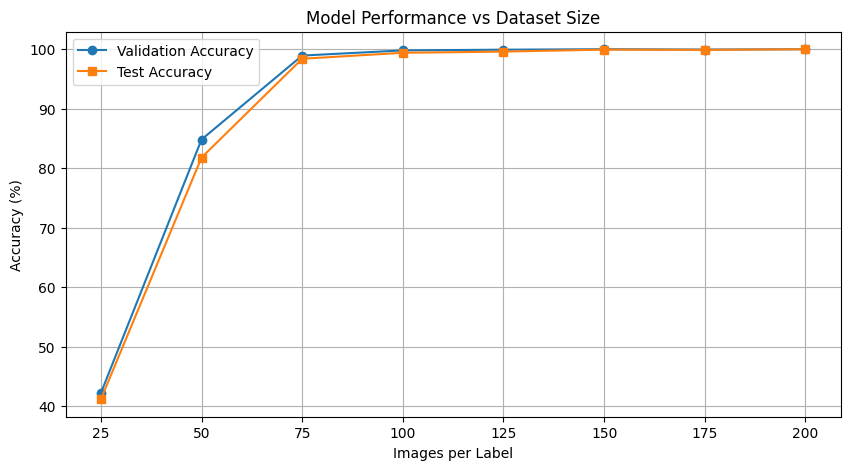

In [40]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.amp import GradScaler, autocast
from torch.utils.data import Subset

class WordImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.images = []
        self.labels = []
        self.label_to_idx = {}
        self.idx_to_label = {}

        # Get all unique words (labels)
        words = set()
        for filename in os.listdir(image_dir):
            word = filename.split('_')[0]
            words.add(word)

        # Create label mappings
        for idx, word in enumerate(sorted(words)):
            self.label_to_idx[word] = idx
            self.idx_to_label[idx] = word

        # Load all images and labels
        for filename in os.listdir(image_dir):
            if filename.endswith('.png'):
                word = filename.split('_')[0]
                self.images.append(os.path.join(image_dir, filename))
                self.labels.append(self.label_to_idx[word])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        image = Image.open(image_path).convert('L')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


class WordCNN(nn.Module):
    def __init__(self, num_classes, activation_fn=nn.ReLU(), dropout_rate=0.4):
        super(WordCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            activation_fn,
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            activation_fn,
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            activation_fn,
            nn.MaxPool2d(2, 2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(128 * 31 * 10, 512),
            activation_fn,
            nn.BatchNorm1d(512),
            nn.Dropout(dropout_rate),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10, device='cuda'):
    best_val_acc = 0.0
    scaler = GradScaler('cuda')

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            with autocast('cuda'):
                outputs = model(images)
                loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_acc = 100 * correct / total

        # Validation
        model.eval()
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_acc = 100 * val_correct / val_total
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, '
              f'Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%')

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')

        scheduler.step()

    return best_val_acc

import matplotlib.pyplot as plt


def test_loop():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    dropout_rate = 0.2
    train_ratio, val_ratio, test_ratio = 0.8, 0.1, 0.1
    dataset_sizes = [25, 50, 75, 100, 125, 150, 175, 200]
    results = {}
    
    for size in dataset_sizes:
        dataset_path = f'content/dataset/easy_{size}'
        transform = transforms.Compose([
            transforms.Resize((248, 80)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])

        dataset = WordImageDataset(dataset_path, transform=transform)
        train_indices, test_indices = train_test_split(range(len(dataset)), test_size=test_ratio, random_state=42)
        train_indices, val_indices = train_test_split(train_indices, test_size=val_ratio / (1 - test_ratio), random_state=42)
        
        train_dataset = Subset(dataset, train_indices)
        val_dataset = Subset(dataset, val_indices)
        test_dataset = Subset(dataset, test_indices)

        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
        
        model = WordCNN(num_classes=len(dataset.label_to_idx), dropout_rate=dropout_rate).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
        scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
        
        best_val_acc = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=20, device=device)
        
        model.load_state_dict(torch.load('best_model.pth'))
        model.eval()
        test_correct, test_total = 0, 0
        
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()
        
        test_acc = 100 * test_correct / test_total
        results[size] = (best_val_acc, test_acc)
        print(f"Dataset {size} images/label | Val Acc: {best_val_acc:.2f}%, Test Acc: {test_acc:.2f}%")
    
    # Plot results
    sizes = list(results.keys())
    val_accs = [results[size][0] for size in sizes]
    test_accs = [results[size][1] for size in sizes]

    plt.figure(figsize=(10, 5))
    plt.plot(sizes, val_accs, marker='o', label='Validation Accuracy')
    plt.plot(sizes, test_accs, marker='s', label='Test Accuracy')
    plt.xlabel('Images per Label')
    plt.ylabel('Accuracy (%)')
    plt.title('Model Performance vs Dataset Size')
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    test_loop()

Given the results, it is fair to say that 100-125 images per label is the sweet spot where we get resonable accuracy at a lower computation and training time.

## Generation of the hard set
The basic features of this dataset include
- Multiple text fonts
- The text color is not fixed but background is fixed to be white.
- The text is centered.
- The text has random capitalisation.
- Noise is added in the form of random dots of random colors in varying positions.

In [8]:
def add_noise(draw, width, height):
    for _ in range(random.randint(4000, 5000)):
        x, y = random.randint(0, width - 1), random.randint(0, height - 1)
        color = tuple(random.randint(0, 255) for _ in range(3))
        draw.point((x, y), fill=color)

FONTS = [
    "Fonts/akira.ttf",
    "Fonts/dejavu-sans-bold.ttf",
    "Fonts/Roboto-Italic.ttf",
    "Fonts/Roboto.ttf",
    "Fonts/Harabara.ttf",
    "Fonts/Designer.ttf",
    "Fonts/OpenSans-Italic.ttf",
    "Fonts/OpenSans-Regular.ttf"
]

In [21]:
if os.path.exists("content/dataset/hard"):
    shutil.rmtree("content/dataset/hard")

if not os.path.exists("content/dataset"):
    os.makedirs("content/dataset")
if not os.path.exists("content/dataset/hard"):
    os.makedirs("content/dataset/hard")

def generate_hard_set():
    for i in range(0,200):
        for word in words:
            width, height = 248, 80
            # generate image with white only
            img = Image.new("RGB", (width, height), color="white")
            draw = ImageDraw.Draw(img)
            
            # generate fonts with random fonts and colors
            font = ImageFont.truetype(random.choice(FONTS), size = 30)
            text_color = tuple(random.randint(0, 255) for _ in range(3))
            
            # generate fonts with random capitalization
            word_variation = ''.join(random.choice([c.upper(), c.lower()]) for c in word)
            text_bbox = font.getbbox(word)
            text_width = text_bbox[2] - text_bbox[0]
            text_height = text_bbox[3] - text_bbox[1]

            position = ((width - text_width) // 2, (height - text_height) // 2)

            draw.text(position, word_variation, fill=text_color, font=font)

            # Add noise
            add_noise(draw, width, height)

            img.save(os.path.join("content/dataset/hard", f"{word}_{i}.png"))

generate_hard_set()

## Changes made to model to account for the hard set
- Changed the first convolutional layer:
    - `nn.Conv2d(1, 32,  kernel_size=3, padding=1)` -> `nn.Conv2d(3, 32,  kernel_size=3, padding=1)`
    - This allows the model to handle RGB images instead of grayscale.
- Updated dataset processing:
    - `Image.open(img_name).convert('L')` -> `Image.open(img_name).convert('RGB')`
    - This ensures images are loaded in color.
- Adjusted normalization:
    - From `mean=[0.5], std=[0.5]` (grayscale) to `mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]`

In [41]:
import os
import random
import shutil
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.amp import GradScaler, autocast

class WordCNN(nn.Module):
    def __init__(self, num_classes, activation_fn=nn.ReLU(), dropout_rate=0.4):
        super(WordCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            activation_fn,
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            activation_fn,
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            activation_fn,
            nn.MaxPool2d(2, 2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(128 * 31 * 10, 512),
            activation_fn,
            nn.BatchNorm1d(512),
            nn.Dropout(dropout_rate),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

class WordImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(root_dir) if f.endswith('.png')]
        self.label_to_idx = {word: idx for idx, word in enumerate(set(f.split('_')[0] for f in self.image_files))}
        self.idx_to_label = {idx: word for word, idx in self.label_to_idx.items()}

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')
        label = self.image_files[idx].split('_')[0]
        label_idx = self.label_to_idx[label]
        if self.transform:
            image = self.transform(image)
        return image, label_idx

def train_model(model, train_loader, val_loader, test_loader, criterion, optimizer, scheduler, num_epochs=10, device='cuda'):
    best_val_acc = 0.0
    scaler = GradScaler()
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            with autocast('cuda'):
                outputs = model(images)
                loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        train_acc = 100 * correct / total
        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        val_acc = 100 * val_correct / val_total
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%')
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')
        scheduler.step()
    model.load_state_dict(torch.load('best_model.pth'))
    model.eval()
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
    test_acc = 100 * test_correct / test_total
    return best_val_acc, test_acc

def test_loop():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    transform = transforms.Compose([
        transforms.Resize((248, 80)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    dataset = WordImageDataset('content/dataset/hard', transform=transform)
    train_indices, temp_indices = train_test_split(range(len(dataset)), test_size=0.2, random_state=42)
    val_indices, test_indices = train_test_split(temp_indices, test_size=0.5, random_state=42)
    train_dataset = torch.utils.data.Subset(dataset, train_indices)
    val_dataset = torch.utils.data.Subset(dataset, val_indices)
    test_dataset = torch.utils.data.Subset(dataset, test_indices)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    model = WordCNN(num_classes=len(dataset.label_to_idx), activation_fn=nn.ReLU(), dropout_rate=0.2).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
    best_val_acc, test_acc = train_model(model, train_loader, val_loader, test_loader, criterion, optimizer, scheduler, num_epochs=20, device=device)
    print("\nFinal Results:")
    print(f"Best Validation Accuracy: {best_val_acc:.2f}%")
    print(f"Test Accuracy: {test_acc:.2f}%")

if __name__ == "__main__":
    test_loop()


Epoch [1/20], Loss: 3.4642, Train Acc: 18.02%, Val Acc: 44.05%
Epoch [2/20], Loss: 1.4816, Train Acc: 61.86%, Val Acc: 67.90%
Epoch [3/20], Loss: 0.8954, Train Acc: 76.43%, Val Acc: 76.25%
Epoch [4/20], Loss: 0.6518, Train Acc: 82.19%, Val Acc: 83.90%
Epoch [5/20], Loss: 0.5151, Train Acc: 85.34%, Val Acc: 85.35%
Epoch [6/20], Loss: 0.3357, Train Acc: 90.89%, Val Acc: 91.10%
Epoch [7/20], Loss: 0.2782, Train Acc: 92.83%, Val Acc: 92.60%
Epoch [8/20], Loss: 0.2573, Train Acc: 93.55%, Val Acc: 92.25%
Epoch [9/20], Loss: 0.2346, Train Acc: 93.91%, Val Acc: 93.20%
Epoch [10/20], Loss: 0.2180, Train Acc: 94.35%, Val Acc: 93.10%
Epoch [11/20], Loss: 0.2015, Train Acc: 94.89%, Val Acc: 93.20%
Epoch [12/20], Loss: 0.1934, Train Acc: 95.27%, Val Acc: 93.35%
Epoch [13/20], Loss: 0.1939, Train Acc: 95.23%, Val Acc: 93.15%
Epoch [14/20], Loss: 0.1961, Train Acc: 94.99%, Val Acc: 94.05%
Epoch [15/20], Loss: 0.1955, Train Acc: 95.04%, Val Acc: 93.50%
Epoch [16/20], Loss: 0.1885, Train Acc: 95.08%, V

A simple increase from 100 images to 200 images per label showed significant increase in accuracy. The hard set thus benefits greatly from the amount of images to allow the model to overcome underfitting. The high compute time in training however hindered me in doing further tests on larger datasets.
- Model accuracy 100 images per label 77.0%
- Model accuracy 200 images per label 93.70%

Lets now look at what happens if we just convert the hardset to compute grayscale images. Colors may play a huge effect in the training of the model and we need to check only the effects of noise and font differences.

In [27]:
def add_gray_noise(draw, width, height):
    for _ in range(random.randint(4000, 5000)):
        x, y = random.randint(0, width - 1), random.randint(0, height - 1)
        gray_value = random.randint(0, 255)  # Single grayscale intensity
        draw.point((x, y), fill=gray_value)

if os.path.exists("content/dataset/grayhard"):
    shutil.rmtree("content/dataset/grayhard")

if not os.path.exists("content/dataset"):
    os.makedirs("content/dataset")
if not os.path.exists("content/dataset/grayhard"):
    os.makedirs("content/dataset/grayhard")

def generate_grayhard_set():
    for i in range(0,200):
        for word in words:
            width, height = 248, 80
            img = Image.new("L", (width, height), color=255)  # "L" mode for grayscale
            draw = ImageDraw.Draw(img)
            
            # Generate fonts with random selection
            font = ImageFont.truetype(random.choice(FONTS), size=30)
            
            # Grayscale text color (single intensity for R, G, and B)
            gray_text_color = random.randint(0, 255)
            
            # Generate random capitalization
            word_variation = ''.join(random.choice([c.upper(), c.lower()]) for c in word)
            text_bbox = font.getbbox(word)
            text_width = text_bbox[2] - text_bbox[0]
            text_height = text_bbox[3] - text_bbox[1]

            position = ((width - text_width) // 2, (height - text_height) // 2)

            draw.text(position, word_variation, fill=gray_text_color, font=font)

            # Add grayscale noise
            add_gray_noise(draw, width, height)

            # Save image
            img.save(os.path.join("content/dataset/grayhard", f"{word}_{i}.png"))

generate_grayhard_set()


In [29]:
import os
import random
import shutil
from PIL import Image, ImageDraw, ImageFont
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.amp import GradScaler, autocast

# Define the WordCNN class with grayscale input support
class WordCNN(nn.Module):
    def __init__(self, num_classes, activation_fn=nn.ReLU(), dropout_rate=0.4):
        super(WordCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # Grayscale input (1 channel)
            nn.BatchNorm2d(32),
            activation_fn,
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            activation_fn,
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            activation_fn,
            nn.MaxPool2d(2, 2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(128 * 31 * 10, 512),
            activation_fn,
            nn.BatchNorm1d(512),
            nn.Dropout(dropout_rate),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Custom Dataset Class
class WordImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(root_dir) if f.endswith('.png')]
        self.label_to_idx = {word: idx for idx, word in enumerate(set(f.split('_')[0] for f in self.image_files))}
        self.idx_to_label = {idx: word for word, idx in self.label_to_idx.items()}

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_name).convert('L')  # Convert to grayscale
        label = self.image_files[idx].split('_')[0]
        label_idx = self.label_to_idx[label]

        if self.transform:
            image = self.transform(image)

        return image, label_idx

# Training function
def train_model(model, train_loader, val_loader, test_loader, criterion, optimizer, scheduler, num_epochs=10, device='cuda'):
    best_val_acc = 0.0
    scaler = GradScaler()

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            with autocast('cuda'):
                outputs = model(images)
                loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_acc = 100 * correct / total

        # Validation
        model.eval()
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_acc = 100 * val_correct / val_total
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, '
              f'Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%')

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')

        scheduler.step()

    # Final test evaluation
    model.load_state_dict(torch.load('best_model.pth'))
    model.eval()
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_acc = 100 * test_correct / test_total
    return best_val_acc, test_acc

# Testing loop with different activation functions and dropout rates
def test_loop():
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Data transforms with augmentation (Grayscale only)
    transform = transforms.Compose([
        transforms.Resize((248, 80)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),  # Converts to (1, H, W) for grayscale
        transforms.Normalize(mean=[0.5], std=[0.5])  # Single-channel normalization
    ])

    # Load dataset
    dataset = WordImageDataset('content/dataset/grayhard', transform=transform)

    # First split: 80% train, 20% temp
    train_indices, temp_indices = train_test_split(
        range(len(dataset)), test_size=0.2, random_state=42)
    
    # Second split: Split the temp into validation (10%) and test (10%)
    val_indices, test_indices = train_test_split(
        temp_indices, test_size=0.5, random_state=42)

    # Create subsets
    train_dataset = torch.utils.data.Subset(dataset, train_indices)
    val_dataset = torch.utils.data.Subset(dataset, val_indices)
    test_dataset = torch.utils.data.Subset(dataset, test_indices)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    print(f"\nTesting with 80:10:10 split")
    print(f"Training samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")
    print(f"Test samples: {len(test_dataset)}")

    model = WordCNN(num_classes=len(dataset.label_to_idx), activation_fn=nn.ReLU(), dropout_rate=0.2).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

    best_val_acc, test_acc = train_model(
        model, train_loader, val_loader, test_loader, 
        criterion, optimizer, scheduler, num_epochs=20, device=device
    )

    # Print results
    print("\nFinal Results:")
    print(f"Best Validation Accuracy: {best_val_acc:.2f}%")
    print(f"Test Accuracy: {test_acc:.2f}%")

if __name__ == "__main__":
    test_loop()



Testing with 80:10:10 split
Training samples: 16000
Validation samples: 2000
Test samples: 2000
Epoch [1/20], Loss: 3.6940, Train Acc: 14.96%, Val Acc: 39.00%
Epoch [2/20], Loss: 2.1567, Train Acc: 47.82%, Val Acc: 51.40%
Epoch [3/20], Loss: 1.7127, Train Acc: 58.29%, Val Acc: 60.45%
Epoch [4/20], Loss: 1.4756, Train Acc: 63.88%, Val Acc: 58.95%
Epoch [5/20], Loss: 1.3108, Train Acc: 67.85%, Val Acc: 68.95%
Epoch [6/20], Loss: 1.0753, Train Acc: 73.92%, Val Acc: 72.85%
Epoch [7/20], Loss: 0.9985, Train Acc: 75.67%, Val Acc: 73.75%
Epoch [8/20], Loss: 0.9678, Train Acc: 76.72%, Val Acc: 74.80%
Epoch [9/20], Loss: 0.9327, Train Acc: 77.38%, Val Acc: 75.15%
Epoch [10/20], Loss: 0.9081, Train Acc: 78.04%, Val Acc: 75.65%
Epoch [11/20], Loss: 0.8605, Train Acc: 79.20%, Val Acc: 75.30%
Epoch [12/20], Loss: 0.8617, Train Acc: 78.93%, Val Acc: 73.90%
Epoch [13/20], Loss: 0.8532, Train Acc: 79.13%, Val Acc: 75.20%
Epoch [14/20], Loss: 0.8474, Train Acc: 79.59%, Val Acc: 75.60%
Epoch [15/20], L

This was a weird result contradicting our hypothesis. However on further investigation, the loss of accuracy can be attributed to:

1. Loss of Color Information
    - Many images contain essential features in color escpecially the text having the same color but in grayscale, it is harder to differentiate between the text and the noise. Removal of the color channel information, reduces accuracyy as it is important for distinguishing between noise and text.
2. Reduced Feature Space
    - Color images (RGB) have three channels, meaning the model gets three different views of the same image. Grayscale images have only one channel, reducing the amount of information available to learn meaningful patterns.
3. Weaker Edge Detection
    - CNNs often learn to detect edges and textures early in the network, and color can play a crucial role in detecting these edges. When converted to grayscale, color-based contrast and edge information is lost.

Lets test one more theory where we fix the text color to be black instead of varying. This will help us understand the true effect (positive/negative) on classification.

In [30]:
def add_gray_noise(draw, width, height):
    for _ in range(random.randint(4000, 5000)):
        x, y = random.randint(0, width - 1), random.randint(0, height - 1)
        gray_value = random.randint(0, 255)  # Single grayscale intensity
        draw.point((x, y), fill=gray_value)

if os.path.exists("content/dataset/grayhardblacktext"):
    shutil.rmtree("content/dataset/grayhardblacktext")

if not os.path.exists("content/dataset"):
    os.makedirs("content/dataset")
if not os.path.exists("content/dataset/grayhardblacktext"):
    os.makedirs("content/dataset/grayhardblacktext")

def generate_grayhardblacktext_set():
    for i in range(0,200):
        for word in words:
            width, height = 248, 80
            img = Image.new("L", (width, height), color=255)  # "L" mode for grayscale
            draw = ImageDraw.Draw(img)
            
            # Generate fonts with random selection
            font = ImageFont.truetype(random.choice(FONTS), size=30)
            
            # Grayscale text color (single intensity for R, G, and B)
            gray_text_color = 0
            
            # Generate random capitalization
            word_variation = ''.join(random.choice([c.upper(), c.lower()]) for c in word)
            text_bbox = font.getbbox(word)
            text_width = text_bbox[2] - text_bbox[0]
            text_height = text_bbox[3] - text_bbox[1]

            position = ((width - text_width) // 2, (height - text_height) // 2)

            draw.text(position, word_variation, fill=gray_text_color, font=font)

            # Add grayscale noise
            add_gray_noise(draw, width, height)

            # Save image
            img.save(os.path.join("content/dataset/grayhardblacktext", f"{word}_{i}.png"))

generate_grayhardblacktext_set()


In [31]:
import os
import random
import shutil
from PIL import Image, ImageDraw, ImageFont
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.amp import GradScaler, autocast

# Define the WordCNN class with grayscale input support
class WordCNN(nn.Module):
    def __init__(self, num_classes, activation_fn=nn.ReLU(), dropout_rate=0.4):
        super(WordCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # Grayscale input (1 channel)
            nn.BatchNorm2d(32),
            activation_fn,
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            activation_fn,
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            activation_fn,
            nn.MaxPool2d(2, 2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(128 * 31 * 10, 512),
            activation_fn,
            nn.BatchNorm1d(512),
            nn.Dropout(dropout_rate),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Custom Dataset Class
class WordImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(root_dir) if f.endswith('.png')]
        self.label_to_idx = {word: idx for idx, word in enumerate(set(f.split('_')[0] for f in self.image_files))}
        self.idx_to_label = {idx: word for word, idx in self.label_to_idx.items()}

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_name).convert('L')  # Convert to grayscale
        label = self.image_files[idx].split('_')[0]
        label_idx = self.label_to_idx[label]

        if self.transform:
            image = self.transform(image)

        return image, label_idx

# Training function
def train_model(model, train_loader, val_loader, test_loader, criterion, optimizer, scheduler, num_epochs=10, device='cuda'):
    best_val_acc = 0.0
    scaler = GradScaler()

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            with autocast('cuda'):
                outputs = model(images)
                loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_acc = 100 * correct / total

        # Validation
        model.eval()
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_acc = 100 * val_correct / val_total
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, '
              f'Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%')

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')

        scheduler.step()

    # Final test evaluation
    model.load_state_dict(torch.load('best_model.pth'))
    model.eval()
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_acc = 100 * test_correct / test_total
    return best_val_acc, test_acc

# Testing loop with different activation functions and dropout rates
def test_loop():
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Data transforms with augmentation (Grayscale only)
    transform = transforms.Compose([
        transforms.Resize((248, 80)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),  # Converts to (1, H, W) for grayscale
        transforms.Normalize(mean=[0.5], std=[0.5])  # Single-channel normalization
    ])

    # Load dataset
    dataset = WordImageDataset('content/dataset/grayhard', transform=transform)

    # First split: 80% train, 20% temp
    train_indices, temp_indices = train_test_split(
        range(len(dataset)), test_size=0.2, random_state=42)
    
    # Second split: Split the temp into validation (10%) and test (10%)
    val_indices, test_indices = train_test_split(
        temp_indices, test_size=0.5, random_state=42)

    # Create subsets
    train_dataset = torch.utils.data.Subset(dataset, train_indices)
    val_dataset = torch.utils.data.Subset(dataset, val_indices)
    test_dataset = torch.utils.data.Subset(dataset, test_indices)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    print(f"\nTesting with 80:10:10 split")
    print(f"Training samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")
    print(f"Test samples: {len(test_dataset)}")

    model = WordCNN(num_classes=len(dataset.label_to_idx), activation_fn=nn.ReLU(), dropout_rate=0.2).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

    best_val_acc, test_acc = train_model(
        model, train_loader, val_loader, test_loader, 
        criterion, optimizer, scheduler, num_epochs=20, device=device
    )

    # Print results
    print("\nFinal Results:")
    print(f"Best Validation Accuracy: {best_val_acc:.2f}%")
    print(f"Test Accuracy: {test_acc:.2f}%")

if __name__ == "__main__":
    test_loop()


Testing with 80:10:10 split
Training samples: 16000
Validation samples: 2000
Test samples: 2000
Epoch [1/20], Loss: 3.9995, Train Acc: 9.51%, Val Acc: 30.65%
Epoch [2/20], Loss: 2.3559, Train Acc: 43.01%, Val Acc: 49.30%
Epoch [3/20], Loss: 1.7935, Train Acc: 55.86%, Val Acc: 60.55%
Epoch [4/20], Loss: 1.5340, Train Acc: 62.74%, Val Acc: 62.65%
Epoch [5/20], Loss: 1.3563, Train Acc: 66.79%, Val Acc: 64.40%
Epoch [6/20], Loss: 1.1029, Train Acc: 73.16%, Val Acc: 72.60%
Epoch [7/20], Loss: 1.0263, Train Acc: 75.08%, Val Acc: 73.15%
Epoch [8/20], Loss: 0.9965, Train Acc: 75.86%, Val Acc: 73.30%
Epoch [9/20], Loss: 0.9652, Train Acc: 76.41%, Val Acc: 73.75%
Epoch [10/20], Loss: 0.9273, Train Acc: 77.51%, Val Acc: 74.95%
Epoch [11/20], Loss: 0.9010, Train Acc: 78.26%, Val Acc: 75.20%
Epoch [12/20], Loss: 0.8944, Train Acc: 78.05%, Val Acc: 75.10%
Epoch [13/20], Loss: 0.8889, Train Acc: 78.36%, Val Acc: 74.75%
Epoch [14/20], Loss: 0.8939, Train Acc: 77.94%, Val Acc: 75.05%
Epoch [15/20], Lo

That did not seem to work. Thus color is an important feature for classification as even after making the text black, the model is still having issues in detecting and classifying the test correctly. Finally lets see what happens when we train the model on a combined dataset of easy to hard in a 2:3 ratio.

In [32]:
if os.path.exists("content/dataset/combined"):
    shutil.rmtree("content/dataset/combined")

if not os.path.exists("content/dataset"):
    os.makedirs("content/dataset")
if not os.path.exists("content/dataset/combined"):
    os.makedirs("content/dataset/combined")

def generate_combined_set():
    for i in range(0,167):
        for word in words:
            width, height = 248, 80
            # generate image with white only
            img = Image.new("RGB", (width, height), color="white")
            draw = ImageDraw.Draw(img)
            
            # generate fonts with random fonts and colors
            font = ImageFont.truetype(random.choice(FONTS), size = 30)
            text_color = tuple(random.randint(0, 255) for _ in range(3))
            
            # generate fonts with random capitalization
            word_variation = ''.join(random.choice([c.upper(), c.lower()]) for c in word)
            text_bbox = font.getbbox(word)
            text_width = text_bbox[2] - text_bbox[0]
            text_height = text_bbox[3] - text_bbox[1]

            position = ((width - text_width) // 2, (height - text_height) // 2)

            draw.text(position, word_variation, fill=text_color, font=font)

            # Add noise
            add_noise(draw, width, height)

            img.save(os.path.join("content/dataset/combined", f"{word}_{i}.png"))
    font_path = "Fonts/OpenSans-Regular.ttf"
    for i in range(167,200):
        for word in words:
            width, height = 250, 80
            color = (255, 255, 255)
            image = Image.new("RGB", (width, height), color)
            draw = ImageDraw.Draw(image)
            try:
                font = ImageFont.truetype(font_path, 36)
            except OSError as e:
                print(f"Error loading font: {e}")
                return
            text = word.title()
            text_bbox = font.getbbox(word)
            text_width = text_bbox[2] - text_bbox[0]
            text_height = text_bbox[3] - text_bbox[1]
            x = random.randint((width - text_width)//8, 7*((width - text_width)//8))
            y = random.randint((height - text_height)//8, 7*((height - text_height)//8))
            position = (x,y)
            text_color = (0, 0, 0)
            draw.text(position, text, font=font, fill=text_color)
            image.save(os.path.join("content/dataset/combined", f"{word}_{i}.png"))

generate_combined_set()


In [33]:
import os
import random
import shutil
from PIL import Image, ImageDraw, ImageFont
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.amp import GradScaler, autocast

# Define the WordCNN class with customizable activation and dropout
class WordCNN(nn.Module):
    def __init__(self, num_classes, activation_fn=nn.ReLU(), dropout_rate=0.4):
        super(WordCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            activation_fn,
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            activation_fn,
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            activation_fn,
            nn.MaxPool2d(2, 2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(128 * 31 * 10, 512),
            activation_fn,
            nn.BatchNorm1d(512),
            nn.Dropout(dropout_rate),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Custom Dataset Class
class WordImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(root_dir) if f.endswith('.png')]
        self.label_to_idx = {word: idx for idx, word in enumerate(set(f.split('_')[0] for f in self.image_files))}
        self.idx_to_label = {idx: word for word, idx in self.label_to_idx.items()}

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_name).convert('L')  # Convert to grayscale
        label = self.image_files[idx].split('_')[0]
        label_idx = self.label_to_idx[label]

        if self.transform:
            image = self.transform(image)

        return image, label_idx

# Training function
def train_model(model, train_loader, val_loader, test_loader, criterion, optimizer, scheduler, num_epochs=10, device='cuda'):
    best_val_acc = 0.0
    scaler = GradScaler()

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            with autocast('cuda'):
                outputs = model(images)
                loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_acc = 100 * correct / total

        # Validation
        model.eval()
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_acc = 100 * val_correct / val_total
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, '
              f'Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%')

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')

        scheduler.step()

    # Final test evaluation
    model.load_state_dict(torch.load('best_model.pth'))
    model.eval()
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_acc = 100 * test_correct / test_total
    return best_val_acc, test_acc

# Testing loop with different activation functions and dropout rates
def test_loop():
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Data transforms with augmentation
    transform = transforms.Compose([
        transforms.Resize((248, 80)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])

    # Load dataset
    dataset = WordImageDataset('content/dataset/combined', transform=transform)

    # First split: 80% train, 20% temp
    train_indices, temp_indices = train_test_split(
        range(len(dataset)), test_size=0.2, random_state=42)
    
    # Second split: Split the temp into validation (10%) and test (10%)
    val_indices, test_indices = train_test_split(
        temp_indices, test_size=0.5, random_state=42)

    # Create subsets
    train_dataset = torch.utils.data.Subset(dataset, train_indices)
    val_dataset = torch.utils.data.Subset(dataset, val_indices)
    test_dataset = torch.utils.data.Subset(dataset, test_indices)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    print(f"\nTesting with 80:10:10 split")
    print(f"Training samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")
    print(f"Test samples: {len(test_dataset)}")

    model = WordCNN(num_classes=len(dataset.label_to_idx), activation_fn=nn.ReLU(), dropout_rate=0.2).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

    best_val_acc, test_acc = train_model(
        model, train_loader, val_loader, test_loader, 
        criterion, optimizer, scheduler, num_epochs=20, device=device
    )

    # Print results
    print("\nFinal Results:")
    print(f"Best Validation Accuracy: {best_val_acc:.2f}%")
    print(f"Test Accuracy: {test_acc:.2f}%")

if __name__ == "__main__":
    test_loop()


Testing with 80:10:10 split
Training samples: 16000
Validation samples: 2000
Test samples: 2000
Epoch [1/20], Loss: 4.0784, Train Acc: 7.36%, Val Acc: 17.35%
Epoch [2/20], Loss: 2.5464, Train Acc: 37.41%, Val Acc: 47.60%
Epoch [3/20], Loss: 1.8283, Train Acc: 54.16%, Val Acc: 49.60%
Epoch [4/20], Loss: 1.4340, Train Acc: 63.01%, Val Acc: 61.90%
Epoch [5/20], Loss: 1.1781, Train Acc: 68.79%, Val Acc: 69.25%
Epoch [6/20], Loss: 0.8409, Train Acc: 78.35%, Val Acc: 77.25%
Epoch [7/20], Loss: 0.7549, Train Acc: 80.11%, Val Acc: 78.95%
Epoch [8/20], Loss: 0.7042, Train Acc: 81.74%, Val Acc: 80.65%
Epoch [9/20], Loss: 0.6689, Train Acc: 82.47%, Val Acc: 81.50%
Epoch [10/20], Loss: 0.6251, Train Acc: 83.89%, Val Acc: 81.80%
Epoch [11/20], Loss: 0.5904, Train Acc: 84.28%, Val Acc: 82.10%
Epoch [12/20], Loss: 0.5710, Train Acc: 85.06%, Val Acc: 82.20%
Epoch [13/20], Loss: 0.5770, Train Acc: 84.99%, Val Acc: 82.20%
Epoch [14/20], Loss: 0.5790, Train Acc: 84.99%, Val Acc: 83.00%
Epoch [15/20], Lo

training the model on this combined dataset worsened the accuracy. Why?
- Increased Variability in the Dataset
    - First 167 images per word → Random fonts, colors, capitalization, and noise.
    - Last 33 images per word → Fixed font (OpenSans-Regular.ttf), black text on a white background, and random text positioning.
- Different Text Positioning in the Second Set
    - In the second part (images 167–200), you are randomizing text positions within (x, y).
    - However, in the first 167 images, the text is centered.

### Generating the Bonus Set
The bonus set has the same features as the hard set with the added complexity of different color backgrounds and text generation.
- Images with green background have the text in the normal order of left ro right
- Images with red background have the text in reversed order of right to left.
- The images have only black text

In [9]:
if os.path.exists("content/dataset/bonus"):
    shutil.rmtree("content/dataset/bonus")

if not os.path.exists("content/dataset"):
    os.makedirs("content/dataset")
if not os.path.exists("content/dataset/bonus"):
    os.makedirs("content/dataset/bonus")


def generate_bonus_set():
    for i in range(0, 200):
        for word in words:
            width, height = 248, 80
            bg_color = random.randint(0, 1)
            if bg_color == 0 :
                bg = "green"
            else :
                bg = "red"

            img = Image.new("RGB", (width, height), color=bg)
            draw = ImageDraw.Draw(img)

            font = ImageFont.truetype(random.choice(FONTS), size=30)
            text_color = "black"

            word_variation = ''.join(random.choice([c.upper(), c.lower()]) for c in word)
            text_bbox = font.getbbox(word)
            text_width = text_bbox[2] - text_bbox[0]
            text_height = text_bbox[3] - text_bbox[1]

            position = ((width - text_width) // 2, (height - text_height) // 2)

            if bg_color == 1:
                final_word = word_variation [::-1]
            else :
                final_word = word_variation

            draw.text(position, final_word, fill=text_color, font=font)

            # Add noise
            add_noise(draw, width, height)

            img.save(os.path.join("content/dataset/bonus", f"{word}_{i}.png"))

generate_bonus_set()

In [10]:
import os
import random
import shutil
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.amp import GradScaler, autocast

class WordCNN(nn.Module):
    def __init__(self, num_classes, activation_fn=nn.ReLU(), dropout_rate=0.4):
        super(WordCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            activation_fn,
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            activation_fn,
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            activation_fn,
            nn.MaxPool2d(2, 2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(128 * 31 * 10, 512),
            activation_fn,
            nn.BatchNorm1d(512),
            nn.Dropout(dropout_rate),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

class WordImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(root_dir) if f.endswith('.png')]
        self.label_to_idx = {word: idx for idx, word in enumerate(set(f.split('_')[0] for f in self.image_files))}
        self.idx_to_label = {idx: word for word, idx in self.label_to_idx.items()}

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')
        label = self.image_files[idx].split('_')[0]
        label_idx = self.label_to_idx[label]
        if self.transform:
            image = self.transform(image)
        return image, label_idx

def train_model(model, train_loader, val_loader, test_loader, criterion, optimizer, scheduler, num_epochs=10, device='cuda'):
    best_val_acc = 0.0
    scaler = GradScaler()
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            with autocast('cuda'):
                outputs = model(images)
                loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        train_acc = 100 * correct / total
        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        val_acc = 100 * val_correct / val_total
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%')
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')
        scheduler.step()
    model.load_state_dict(torch.load('best_model.pth'))
    model.eval()
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
    test_acc = 100 * test_correct / test_total
    return best_val_acc, test_acc

def test_loop():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    transform = transforms.Compose([
        transforms.Resize((248, 80)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    dataset = WordImageDataset('content/dataset/bonus', transform=transform)
    train_indices, temp_indices = train_test_split(range(len(dataset)), test_size=0.2, random_state=42)
    val_indices, test_indices = train_test_split(temp_indices, test_size=0.5, random_state=42)
    train_dataset = torch.utils.data.Subset(dataset, train_indices)
    val_dataset = torch.utils.data.Subset(dataset, val_indices)
    test_dataset = torch.utils.data.Subset(dataset, test_indices)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    model = WordCNN(num_classes=len(dataset.label_to_idx), activation_fn=nn.ReLU(), dropout_rate=0.2).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
    best_val_acc, test_acc = train_model(model, train_loader, val_loader, test_loader, criterion, optimizer, scheduler, num_epochs=20, device=device)
    print("\nFinal Results:")
    print(f"Best Validation Accuracy: {best_val_acc:.2f}%")
    print(f"Test Accuracy: {test_acc:.2f}%")

if __name__ == "__main__":
    test_loop()


Epoch [1/20], Loss: 3.9239, Train Acc: 8.12%, Val Acc: 21.35%
Epoch [2/20], Loss: 1.9339, Train Acc: 48.26%, Val Acc: 57.35%
Epoch [3/20], Loss: 1.1295, Train Acc: 68.33%, Val Acc: 75.35%
Epoch [4/20], Loss: 0.7937, Train Acc: 76.68%, Val Acc: 80.00%
Epoch [5/20], Loss: 0.5889, Train Acc: 82.54%, Val Acc: 87.75%
Epoch [6/20], Loss: 0.3537, Train Acc: 90.02%, Val Acc: 92.55%
Epoch [7/20], Loss: 0.2938, Train Acc: 91.95%, Val Acc: 92.85%
Epoch [8/20], Loss: 0.2692, Train Acc: 92.47%, Val Acc: 93.65%
Epoch [9/20], Loss: 0.2397, Train Acc: 93.44%, Val Acc: 94.70%
Epoch [10/20], Loss: 0.2241, Train Acc: 94.01%, Val Acc: 94.95%
Epoch [11/20], Loss: 0.2085, Train Acc: 94.29%, Val Acc: 95.05%
Epoch [12/20], Loss: 0.1988, Train Acc: 94.66%, Val Acc: 95.15%
Epoch [13/20], Loss: 0.2017, Train Acc: 94.57%, Val Acc: 95.85%
Epoch [14/20], Loss: 0.1931, Train Acc: 94.90%, Val Acc: 95.65%
Epoch [15/20], Loss: 0.1951, Train Acc: 94.86%, Val Acc: 95.20%
Epoch [16/20], Loss: 0.1935, Train Acc: 94.88%, Va

Running the same code on bonus set results in a similar (or in this speciific case better) accuracy which can be attributed to 
1. The bonus set has a background that is either green or red, while the hard set always has a white background. Since text color in the bonus set is always black, the contrast between text and background is high, making it easier for the CNN to distinguish characters. In contrast, the hard set uses random text colors on a white background, which can sometimes result in lower contrast (e.g., light-colored text on white), making character recognition harder.
2. CNNs can learn to handle predictable transformations (like reversing text) which does not have a negative effect in classification.
3. Both datasets add random noise, but in the hard set, the combination of random text colors and random noise makes feature extraction more difficult. In the bonus set, even with noise, the black text remains highly visible due to strong contrast.
4. In the hard set, the text color changes along with the font, adding more complexity. The CNN has to learn both color variation and font variation at the same time, making it harder to generalize.